# Data importation

In [41]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import networkx as nx
import re

%matplotlib inline

In [42]:
info = pd.read_csv(
    "node_information.csv", 
    header= None, 
    names=["Id", "year", "title", "authors", "journal", "abstract"],
    sep=",",
    index_col = 0
)

In [43]:
X_train = pd.read_csv("training_set.txt", sep=" ", header=None)
X_test = pd.read_csv("testing_set.txt", sep=" ", header=None)
y_train = X_train[2]
X_train.drop([2], axis = 1, inplace = True)

print info.shape, X_train.shape, X_test.shape

(27770, 5) (615512, 2) (32648, 2)


In [4]:
######################
### FOR VALIDATION ###
######################


#####################
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
#####################

#####################
small_portion_to_train = 50000
small_portion_to_test  = 5000
#X_train = X_train[:small_portion_to_train]
#y_train = y_train[:small_portion_to_train]

#X_test  = X_test[:small_portion_to_test]
#y_test = y_test[:small_portion_to_test]
#####################

# Feature Preprocess

- list_authors is the list of authors in the papers
- list_universities is the list where the authors are from

In [5]:
def universities_to_keep(authors, universities):
    while('(' in authors and ')' in authors):
        universities.append( authors[authors.find('(')+1 : authors.find(')')] )
        authors = authors[: authors.find('(')] + authors[ authors.find(')')+1 : ]
            
    if '(' in authors:
        universities.append( authors[authors.find('(')+1 : ])
        authors = authors[: authors.find('(')]
    
    return authors, universities


def name_to_keep(author):
    if len(author.split(' ')) <= 1:
        return author
    
    while( author[0] == ' ' and len(author) > 0):
        author = author[1:]
    while( author[-1] == ' ' and len(author) > 0):
        author = author[:-1]
    
    author = author.replace('.', '. ')
    author = author.replace('.  ', '. ')
    name_to_keep = author.split(' ')[0][0] + '. ' + author.split(' ')[-1]

    return name_to_keep

# Transform concatenated names of authors to a list of authors 
list_authors = []
list_universities = []

info['authors'] = info['authors'].replace(np.nan, 'missing')
for authors in info['authors']:
    if authors != 'missing':
        ### split the different authors
        authors = authors.lower()
        
        ### Find the universities included in the name
        universities = []
        authors, universities = universities_to_keep(authors, universities)
        
        ### Split the authors
        authors = re.split(',|&', authors)
        
        ### For each author, check if university, and store it. Also, keep just the names (To be improved)
        authors_in_article = []      
        for author in authors:
            if author != ' ':
                authors_in_article.append(name_to_keep(author))
            
        list_universities.append(universities)
        list_authors.append(authors_in_article)
    else:
        list_universities.append(['missing'])
        list_authors.append(['missing'])   
        
info['authors'] = list_authors
info['universities'] = list_universities

# Topologic features

In [6]:
def make_graph(X_train, y_train, X_test):
    X_train = pd.concat([X_train, y_train], axis = 1)
    X_train = X_train.values
    G = nx.DiGraph()
    for i in range(X_train.shape[0]):
        source = X_train[i,0]
        target = X_train[i,1]
        G.add_node(source)
        G.add_node(target)
        if X_train[i,2] == 1:
            G.add_edge(source,target)
            
    X_test = X_test.values
    for i in range(X_test.shape[0]):
        source = X_test[i,0]
        target = X_test[i,1]
        G.add_node(source)
        G.add_node(target)
        
    return G  

In [7]:
G = make_graph(X_train, y_train, X_test)  

In [8]:
def compute_betweeness_array(X, graph):    
    centrality = nx.degree_centrality(graph)  
    centr = [centrality[x[0]] - centrality[x[1]] for x in X[:]]
    return np.array(centr)

In [9]:
def make_common_neighbors(X, G): 
    G2 = G.to_undirected()
    common_neighbors = [len(set(G2.neighbors(x[0])).intersection(G2.neighbors(x[1]))) for x in X[:]]
    return np.array(common_neighbors)

In [10]:
def make_jaccard(X, G):   
    total_jaccard = nx.jaccard_coefficient(G.to_undirected(), [(x[0],x[1]) for x in X[:]])
    jaccard = [jac for u, v, jac in total_jaccard]
    return np.array(jaccard)

In [11]:
#Difference in inlinks between papers
def compute_diff_inlinks(X, graph):
    in_degrees=graph.in_degree()
    diff_deg = [in_degrees[x[1]] - in_degrees[x[0]] for x in X[:]]
    to_deg = [in_degrees[x[1]] for x in X[:]]
    return diff_deg, to_deg

In [12]:
def create_topologic_features(X, G):
    X_ = X.copy()
    X = X.values
    
    X_['Betweeness centrality'] = compute_betweeness_array(X, G)
    X_['Number common neighbours'] = make_common_neighbors(X, G)
    X_['Jaccard coefficienf'] = make_jaccard(X, G)
    diff_deg, to_deg = compute_diff_inlinks(X, G)
    X_['Difference in inlinks coefficient'] = diff_deg
    X_["Number of times to cited"] = to_deg
    
    return X_

In [13]:
%%time
X_train = create_topologic_features(X_train, G)
X_test = create_topologic_features(X_test, G)

CPU times: user 1min 7s, sys: 491 ms, total: 1min 7s
Wall time: 1min 8s


# Semantic features
- Cosine similarity within the titles as tf-idf
- Cosine similarity within the abstracts as tf-idf
- Cosine similarity within the titles as word2vec
- Cosine similarity within the abstracts as word2vec

### To try
- Difference cosine similarities?
- Keep the stopwords or not?
- Stemmise the words of not?

# Attribute features

- Difference in publication year
- Number of common authors
- Self-citation
- Same journal
- Number of times "to" cited (Attraction of the "to" paper)

### To try
- Number of times each author of "to" cited [Sum of these number of times] ?
- Number of times each journal cited?
- Number of same university??

In [14]:
def numb_same_authors(authors1, authors2):
    total = 0
    for author in authors1:
        if author in authors2:
            total += 1
    return total

In [15]:
def create_attribute_features(X):
    length = X.shape[0]
    difference_publication_year = np.zeros(length)
    number_same_authors = np.zeros(length)
    self_citation = [0 for x in range(length)]
    same_journal = [0 for x in range(length)]
    
    ### NOT TO OVERFIT WHEN COUNTING : THE INFORMATION ARE AVAILABLE ONLY FOR X_TRAIN ###
    number_times = X_train.groupby(1).count()
    
    i=-1
    for idx, row in X.iterrows():
        i += 1
        ID1 = int(row[0])
        ID2 = int(row[1])
        
        source = info.loc[ID1]
        target = info.loc[ID2]
        
        ### Difference in publication year
        difference_publication_year[i] = source['year'] - target['year']
        
        ### Number of same authors
        common_authors = numb_same_authors(source['authors'], target['authors'])
        number_same_authors[i] = common_authors
        
        ### Self citation ###
        if common_authors >= 1:
            self_citation[i] = 1
            
        ### Same journal ###
        if source['journal'] == target['journal']:
            same_journal[i] = 1
            
        
    X_ = X.copy()
    X_['Diff publication'] = difference_publication_year
    X_['Number same authors'] = number_same_authors
    X_['Self citation'] = self_citation
    X_['Same journal'] = same_journal
    return X_

In [16]:
%%time
X_train = create_attribute_features(X_train)
X_test = create_attribute_features(X_test)

CPU times: user 4min 12s, sys: 1.2 s, total: 4min 13s
Wall time: 4min 12s


In [17]:
X_train.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Diff publication,Number same authors,Self citation,Same journal
0,9510123,9502114,-0.000216,1,0.058824,5,8,0,0,False,True
1,9707075,9604178,-0.002449,20,0.097087,113,124,1,0,False,False
2,9312155,9506142,-0.000144,0,0.000000,1,2,-2,0,False,False
3,9911255,302165,0.000216,0,0.000000,-2,2,-4,0,False,False
4,9701033,209076,-0.000612,0,0.000000,-5,2,-5,0,False,False


In [18]:
X_test.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Diff publication,Number same authors,Self citation,Same journal
0,9807076,9807139,0.001476,0,0.000000,-46,3,0,0,False,False
1,109162,1182,0.009291,24,0.074303,-61,39,1,0,False,False
2,9702187,9510135,-0.018582,59,0.065338,517,726,2,0,False,True
3,111048,110115,-0.000504,21,0.221053,5,16,0,0,False,True
4,9910176,9410073,-0.005150,0,0.000000,143,144,5,0,False,False


# Classifier

In [19]:
def score(pred, real):
    tot = 0
    for i, val in enumerate(real):
        if pred[i] == val:
            tot += 1
    return float(tot)/len(real)

In [20]:
y_train.shape

(615512,)

In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train.drop([0,1], axis = 1), y_train)
pred = rfc.predict(X_test.drop([0,1], axis = 1))

#print score(pred, y_test)

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Diff publication,Number same authors,Self citation,Same journal
0,9510123,9502114,-0.000216,1,0.058824,5,8,0,0,False,True
1,9707075,9604178,-0.002449,20,0.097087,113,124,1,0,False,False
2,9312155,9506142,-0.000144,0,0.000000,1,2,-2,0,False,False
3,9911255,302165,0.000216,0,0.000000,-2,2,-4,0,False,False
4,9701033,209076,-0.000612,0,0.000000,-5,2,-5,0,False,False
5,9710020,9709228,0.000108,14,0.237288,7,16,0,0,False,False
6,9901042,9510135,-0.024416,12,0.015228,690,726,4,1,True,False
7,209146,9502077,-0.002557,0,0.000000,63,63,7,0,False,False
8,9705079,9702201,-0.002125,5,0.036765,68,76,0,0,False,False
9,3016,9207067,-0.000936,0,0.000000,27,30,8,0,False,False


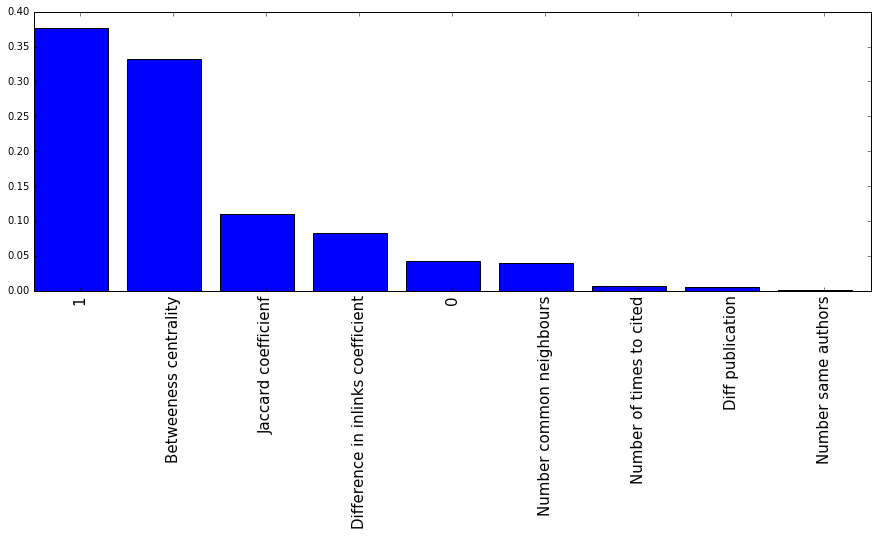

In [39]:
plt.figure(figsize=(15, 5))
X_columns = X_train.columns
ordering = np.argsort(rfc.feature_importances_)[::-1]

importances = rfc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [34]:
def make_submission(predicted_label, name = 'submit.csv'):
    submit_d = d = {'id' : pd.Series(np.arange(predicted_label.shape[0]).astype(int)),
                    'category' : pd.Series(predicted_label).astype(int)}
    submit = pd.DataFrame(submit_d, columns=["id","category"])
    submit.to_csv(name,index=False)
    return submit


In [35]:


submit = make_submission(pred)


In [28]:
submit.shape

(32648, 2)

In [25]:
[l for i,l in enumerate(pred)]

[0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
